# Clustering Models for Plant Seedlings


Data Mining Final Project - Plant Seedling Classfification

Author： Xintian Su

2020.8

Codes below were ran on google colab and then transferred into notebook file.



## Bassic Set-up

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#/content/drive/Shared drives/Data Mining Project/Image data


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from keras.preprocessing import image

from sklearn.model_selection import train_test_split
import itertools


In [3]:
# Mount the data folder from Google Drive
train_dir = '/content/drive/Shared drives/Data Mining Project/Original Data (Do Not Move)/train'
test_dir = '/content/drive/Shared drives/Data Mining Project/Original Data (Do Not Move)/test'


Below are the given species from Train Data. Each image is stored in its folder with the species name

In [4]:
# Given
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
          'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
          'Small-flowered Cranesbill', 'Sugar beet']

num_species = len(SPECIES)

Below cell calculates basic summary of each species, gives a general idea how many images are contained in each species folder

In [ ]:
# Basic summary of each species 
for item in SPECIES:
    print('{} {} images'.format(item, len(os.listdir(os.path.join(train_dir, item)))))
    

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


Create a "train" and "test" data frame that reads all original images from train and test folder. The dataframe contains paths for each image for later reading

In [5]:
# create the train dataframe
train = []
for species_id, item in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, item)):
        train.append(['{}/{}/{}'.format(train_dir,item, file), species_id, item])
train = pd.DataFrame(train, columns=['file', 'species_id', 'item'])
print("the shape of x_train:", train.shape)
train.tail(3)


the shape of x_train: (4750, 3)


,file,species_id,item
4747,/content/drive/Shared drives/Data Mining Proje...,11,Sugar beet
4748,/content/drive/Shared drives/Data Mining Proje...,11,Sugar beet
4749,/content/drive/Shared drives/Data Mining Proje...,11,Sugar beet


In [6]:
# create the test dataframe
test = []

for file in os.listdir(os.path.join(test_dir)):
  test.append(['{}/{}'.format(test_dir,file),file])

test = pd.DataFrame(test, columns=['filepath','file'])
print("the shape of test:", test.shape)
test.tail(3)

the shape of test: (794, 2)


,filepath,file
791,/content/drive/Shared drives/Data Mining Proje...,ffc6f8527.png
792,/content/drive/Shared drives/Data Mining Proje...,ff65bc002.png
793,/content/drive/Shared drives/Data Mining Proje...,fef2ade8c.png


## Resize and Pre-Processing of the Images 


Below functions are created to generating masks,  segementaion on each images to rule out the leave shape,sharpening the shape for better recognition 

In [7]:
# Create a sharpen filter

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

Then image size is reduced to 64*64 and transformed into grey scale. Data is also transformed from 4750*255*255*4 into a 2D numpy array.

In [8]:
# read the image and resize, preprocess to gray scale
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(64,64))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(64,64,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

CPU times: user 49.9 s, sys: 4.75 s, total: 54.7 s
Wall time: 18min 39s


In [9]:
# reshape the data array from 4D to 2D. 
print("the shape of x_train:", x_train.shape)
x_train_2d = np.reshape(x_train,(4750,64*64*4))  
# or: x_train_2d_b = np.reshape(x_train,(4750,-1))    #-1 means unspecified

x_train_2d


the shape of x_train: (4750, 64, 64, 4)


array([[ 24,  46,  78, ...,  66,  70,   0],
       [ 49,  82, 106, ...,  79,  94,   0],
       [ 22,  32,  47, ..., 108, 111, 134],
       ...,
       [ 34,  63,  92, ...,  44,  65,   0],
       [ 79,  93, 105, ...,  76,  95,   0],
       [ 59,  80,  99, ...,  54,  65,   0]], dtype=uint8)

In [12]:
# read the image and resize, preprocess to gray scale for test dataset
# Note: y_test contains the data from orginal "test" data folder, not the train/test split
y_test = []

for i in range(len(test)):
    img = cv2.imread(test['filepath'][i])
    img = cv2.resize(img,dsize=(64,64))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(64,64,1))
    y_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

y_test = np.array(y_test)

In [13]:
# reshape the data array from 4D to 2D. 
print("the shape of y_test:", y_test.shape)
y_test_2d = np.reshape(y_test,(794,-1))  

y_test_2d

the shape of y_test: (794, 64, 64, 4)


array([[ 73, 104, 132, ...,  51,  72,   0],
       [ 98, 115, 131, ...,  81, 101,   0],
       [ 49,  61,  81, ...,  61,  77,   0],
       ...,
       [ 42,  64,  83, ...,  87, 115,   0],
       [ 39,  68,  91, ...,  59,  64,   0],
       [ 65,  84, 101, ...,  39,  55,   0]], dtype=uint8)

Data is normalized from [0..256] to [0..1] scale for better computation in the later clustering models.

In [14]:
# normalize the data
from sklearn.preprocessing import normalize

normalized_images = normalize(x_train_2d)
normalized_images_test = normalize (y_test_2d)

## Hierarchical Clustering


Clustering Technicas are tried in our project in the data exploration stages just to give us a general idea about the data. And we would also like to test out how the techniques taught in class would fit image data

In [15]:
# import the linkage and dendrogram 
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# get the labels for each picture, use picture index 
h_labels = list(train.index)
h_labels_test = list(test.index)

Create UDF to calculate linkage and draw dendrogram based on the mergings. 

In [ ]:
# define UDF to calculate the mergings and plot dendrogram
global mergings
def hierarchy(data, label, method):
  '''
  Calculates linkage and fits the hierarchical clusterings and draw the dendrogram

  Paramters
  ---------
  data: A np array
  label: A list of labels 
  method: choose the method of linkage: 'ward','average','single','complete','median'

  Returns
  -------
  the hierarchical clustering encoded as a linkage matrix, and the plot
  '''
  # Calculate the linkage: mergings
  mergings = linkage(data, method= method)   # use ward   and try others

  # Plot the dendrogram
  fig, ax = plt.subplots(figsize=(15,8))

  dendrogram(
      mergings,
      labels = label,
      leaf_rotation=90,
      leaf_font_size=9
  )
  ax.set_title("Denrograms of normalized image data")
  return mergings


In [ ]:
# define function to list out the groups 

def hier_cluster(mergings, dist): 
  '''
  forms flat clusters from the hierarchical clustering defined by linkage matrix.
  
  Parameters
  ---------
  mergings: the hierarchical clustering encoded with matrix returned by linkage function
  dist:  the threshold to apply when forming clusters 

  Returns
  -------
  A matrix of each images index with its grouping labels 
  
  '''        
  # Use fcluster to extract labels: labels
  labels=fcluster(mergings, dist,criterion='distance')          # set the distance at 4

  # Create a DataFrame with labels and image index as columns: df
  pairs= pd.DataFrame({'labels': labels, 'image index': h_labels})
  print (pairs.sort_values('labels'))

array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.48500000e+03, 9.49000000e+03, 4.70234520e+00, 6.41000000e+02],
       [9.49400000e+03, 9.49500000e+03, 5.30551365e+00, 4.10900000e+03],
       [9.49600000e+03, 9.49700000e+03, 5.71428572e+00, 4.75000000e+03]])

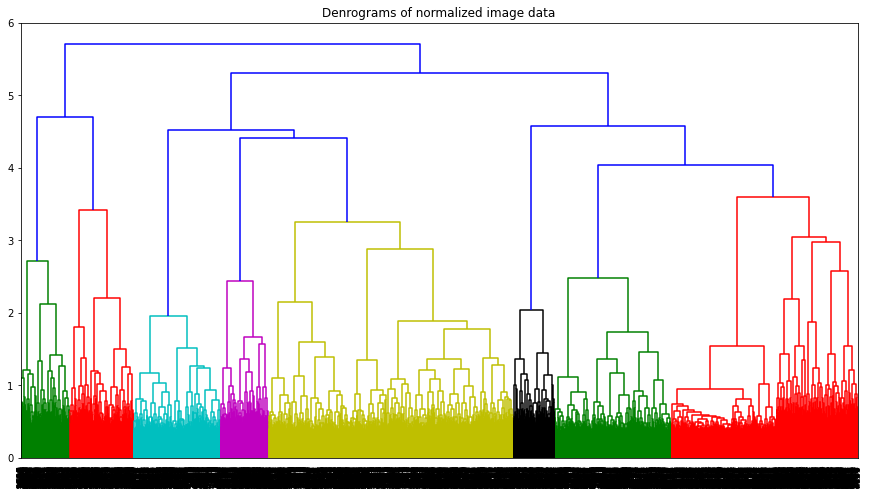

In [ ]:
 hierarchy(normalized_images, h_labels, "ward")

From the dendrogram above using Hierarchical Clustering, if the distance is kept at 4, the 4750 image data is perfectly clustered into 8 groups.  Though the number of species in x_train actually has 12. So the clustering is not accurate. 


array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [6.42000000e+02, 9.49500000e+03, 6.88501859e-01, 4.74500000e+03],
       [9.39400000e+03, 9.49600000e+03, 6.93981465e-01, 4.74800000e+03],
       [8.54300000e+03, 9.49700000e+03, 6.94750948e-01, 4.75000000e+03]])

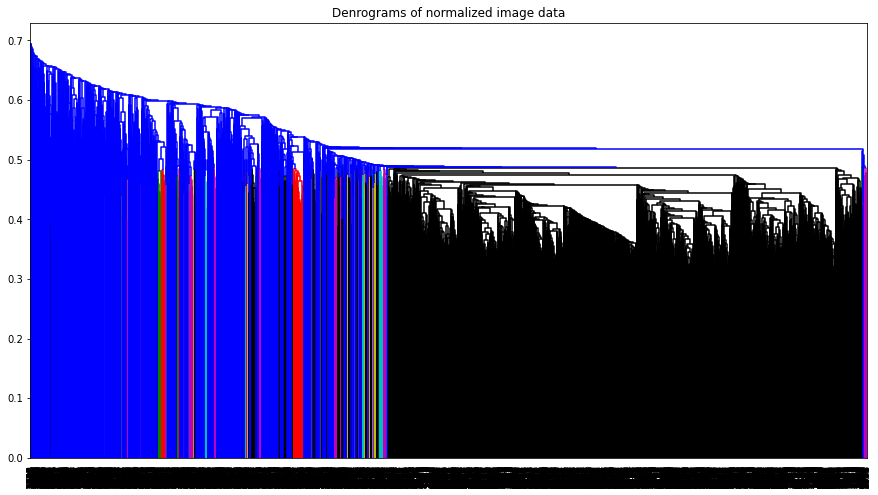

In [ ]:
# Try "average" linkage method
 
 hierarchy(normalized_images, h_labels, "average")

Results from average method are not presentable and is meaningless


In [ ]:
# The original number of species from dataset
print(" the number of species in x_train:" ,len(SPECIES))

 the number of species in x_train: 12


In [16]:
# define UDF to calculate the mergings and plot dendrogram
global mergings

def hierarchy_new(data, label, method,dist):
  '''
  Calculates linkage and fits the hierarchical clusterings and draw the dendrogram

  Paramters
  ---------
  data: A np array
  label: A list of labels 
  method: choose the method of linkage: 'ward','average','single','complete','median'

  Returns
  -------
  the hierarchical clustering encoded as a linkage matrix, and the plot
  '''
  # Calculate the linkage: mergings
  mergings = linkage(data, method= method)   # use ward   and try others

  # Plot the dendrogram
  fig, ax = plt.subplots(figsize=(15,8))

  dendrogram(
      mergings,
      labels = label,
      leaf_rotation=90,
      leaf_font_size=9
  )
  ax.set_title("Denrograms of normalized image data")

  # Use fcluster to extract labels: labels
  labels=fcluster(mergings, dist,criterion='distance')          # set the distance at 4

  # Create a DataFrame with labels and image index as columns: df
  pairs= pd.DataFrame({'labels': labels, 'image index': h_labels})
  print (pairs.sort_values('labels'))
  return mergings

Given the results from "ward" linakage method, try to set the distance on mergings and see how many groups it turns out. Dist = 4 giving a perfect 8 groups of species, meaning some of the species are combined together. 
Various number of distance is tested. 
There are 11 groups if the distance is set to 3.1

      labels  image index
260        1          260
1779       1         1779
1780       1         1780
1781       1         1781
293        1          293
...      ...          ...
2146       8         2146
2148       8         2148
2151       8         2151
2113       8         2113
0          8            0

[4750 rows x 2 columns]


array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.48500000e+03, 9.49000000e+03, 4.70234520e+00, 6.41000000e+02],
       [9.49400000e+03, 9.49500000e+03, 5.30551365e+00, 4.10900000e+03],
       [9.49600000e+03, 9.49700000e+03, 5.71428572e+00, 4.75000000e+03]])

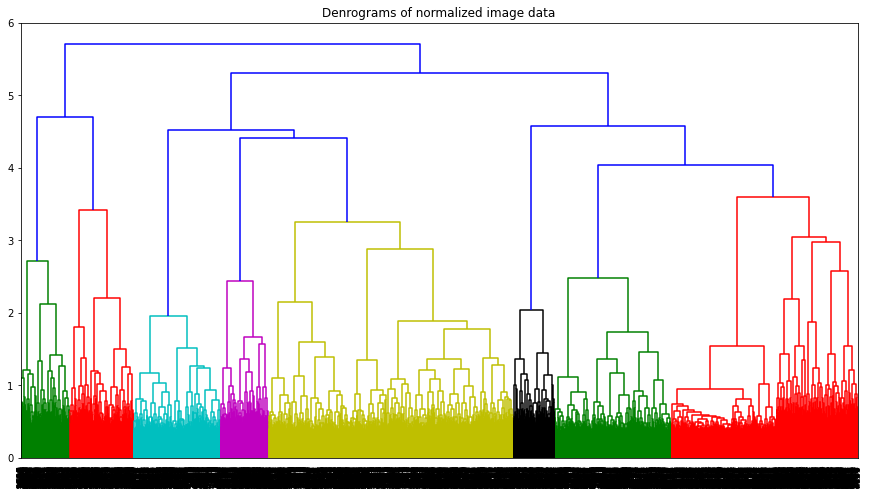

In [ ]:
# Set the distance  = 4 
hierarchy_new(normalized_images, h_labels, 'ward', 4)

      labels  image index
1986       1         1986
4423       1         4423
1814       1         1814
1823       1         1823
1856       1         1856
...      ...          ...
845       10          845
2368      10         2368
815       10          815
2343      10         2343
0         10            0

[4750 rows x 2 columns]


array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.48500000e+03, 9.49000000e+03, 4.70234520e+00, 6.41000000e+02],
       [9.49400000e+03, 9.49500000e+03, 5.30551365e+00, 4.10900000e+03],
       [9.49600000e+03, 9.49700000e+03, 5.71428572e+00, 4.75000000e+03]])

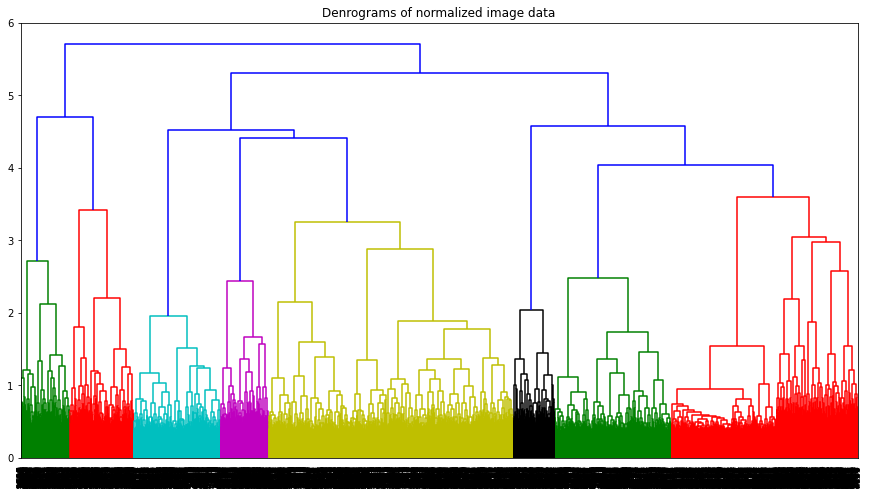

In [ ]:
# set the distance = 3.4
hierarchy_new(normalized_images, h_labels, 'ward', 3.4)

      labels  image index
1986       1         1986
4423       1         4423
1814       1         1814
1823       1         1823
1856       1         1856
...      ...          ...
845       11          845
2368      11         2368
815       11          815
2343      11         2343
0         11            0

[4750 rows x 2 columns]


array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.48500000e+03, 9.49000000e+03, 4.70234520e+00, 6.41000000e+02],
       [9.49400000e+03, 9.49500000e+03, 5.30551365e+00, 4.10900000e+03],
       [9.49600000e+03, 9.49700000e+03, 5.71428572e+00, 4.75000000e+03]])

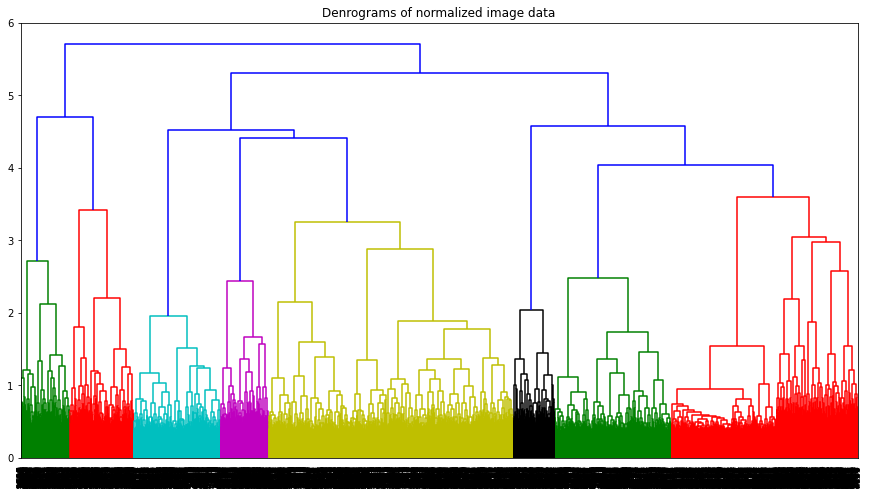

In [ ]:
# set the distance = 3.2
hierarchy_new(normalized_images, h_labels, 'ward', 3.2)

      labels  image index
1986       1         1986
4423       1         4423
1814       1         1814
1823       1         1823
1856       1         1856
...      ...          ...
845       11          845
2368      11         2368
815       11          815
2343      11         2343
0         11            0

[4750 rows x 2 columns]


array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.48500000e+03, 9.49000000e+03, 4.70234520e+00, 6.41000000e+02],
       [9.49400000e+03, 9.49500000e+03, 5.30551365e+00, 4.10900000e+03],
       [9.49600000e+03, 9.49700000e+03, 5.71428572e+00, 4.75000000e+03]])

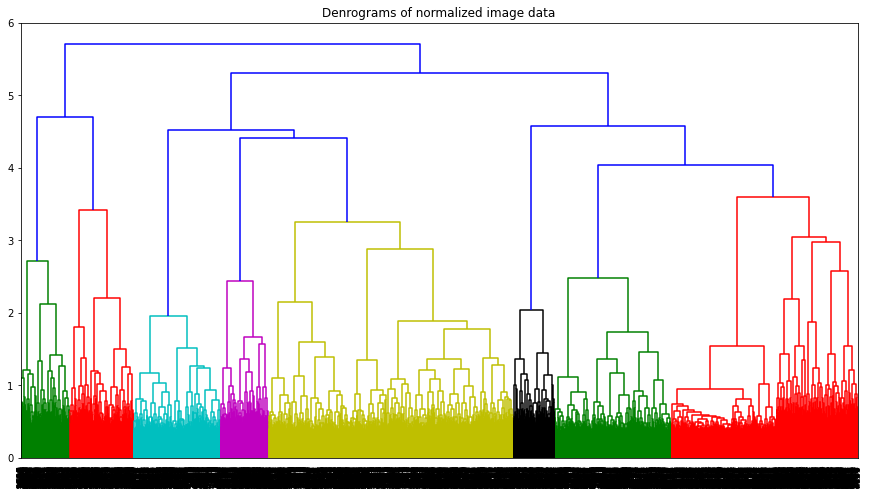

In [ ]:
# set the distance = 3.2

hierarchy_new(normalized_images, h_labels, 'ward', 3.1)

      labels  image index
1986       1         1986
4423       1         4423
1814       1         1814
1823       1         1823
1856       1         1856
...      ...          ...
4111      12         4111
211       12          211
4114      12         4114
2133      12         2133
1666      12         1666

[4750 rows x 2 columns]


array([[1.62600000e+03, 1.65800000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.67500000e+03, 4.75000000e+03, 0.00000000e+00, 3.00000000e+00],
       [4.48200000e+03, 4.60800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.48500000e+03, 9.49000000e+03, 4.70234520e+00, 6.41000000e+02],
       [9.49400000e+03, 9.49500000e+03, 5.30551365e+00, 4.10900000e+03],
       [9.49600000e+03, 9.49700000e+03, 5.71428572e+00, 4.75000000e+03]])

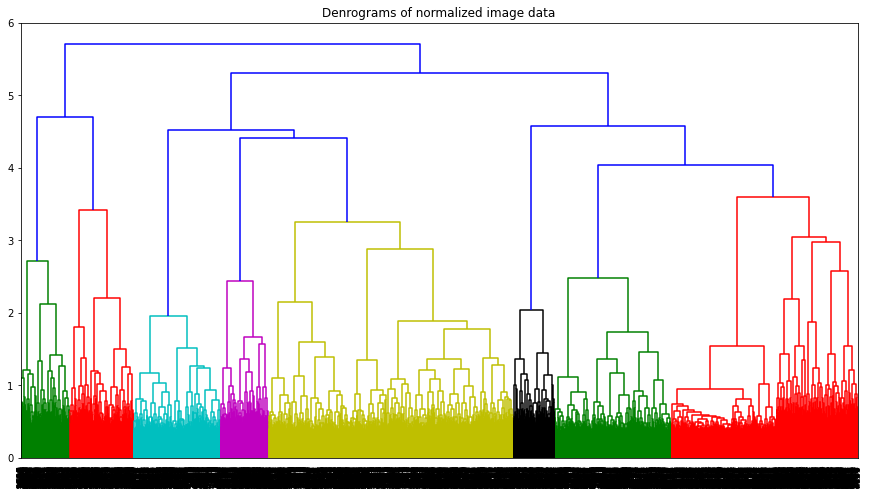

In [17]:
# set the distance = 3.0

hierarchy_new(normalized_images, h_labels, 'ward', 3.0)

### Try the test dataset


In [ ]:
# basic data of test data
len(h_labels)
len(h_labels_test)

794

In [ ]:
# shape of x_train
normalized_images.shape

(4750, 16384)

In [ ]:
# shape of test set
normalized_images_test.shape

(794, 16384)

array([[3.36000000e+02, 4.34000000e+02, 2.36368489e-01, 2.00000000e+00],
       [1.95000000e+02, 7.83000000e+02, 3.06541963e-01, 2.00000000e+00],
       [6.79000000e+02, 6.93000000e+02, 3.10573969e-01, 2.00000000e+00],
       ...,
       [1.57900000e+03, 1.58300000e+03, 2.25312263e+00, 6.85000000e+02],
       [1.57500000e+03, 1.58000000e+03, 2.35159232e+00, 1.09000000e+02],
       [1.58400000e+03, 1.58500000e+03, 2.68929597e+00, 7.94000000e+02]])

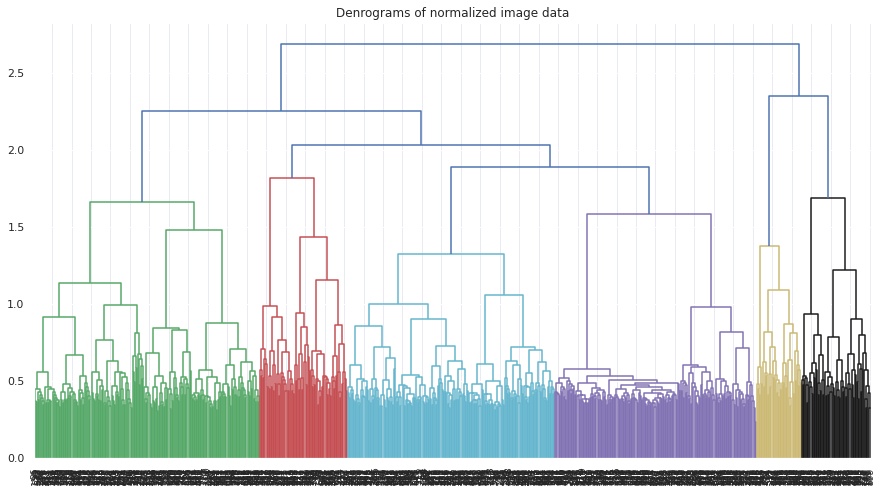

In [ ]:
 hierarchy(normalized_images_test, h_labels_test, "ward")

Test data is obviously clustered into 6 groups, however there are 12 species. It further confirms that hierarchical clusterings is not an accurate fit for our data. 

## DBSCAN



DBSCAN model only works for 2D data, so the dataset used is the same as above hierarchical clustering. 

K-Nearest Neighbour method is used to find the optimum value of epsilon, which turns out to be in the range of (0.3 - 0.5). Clustering result does not vary based on the epsilon chosen in the range. The number of cluster returned is either 0 or 1. 
This clustering does not work well on image data since the plant image is heavily transformed and loosing some discre



In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Find a suitable value for the eps neighborhood
from sklearn.neighbors import NearestNeighbors

def find_eps(data):
    nbrs = NearestNeighbors(n_neighbors=len(data)).fit(data)
    distances, indices = nbrs.kneighbors(data)

    distances = np.sort(distances, axis=0)[:,1]
    
    fig, ax = plt.subplots(figsize=(8,5))

    ax.set_title('The k-NN method')
    ax.set_ylabel('Eps')
    ax.set_xlabel('Points sorted by distance')
    plt.plot(distances)
    plt.grid()
    
    return ax

In [ ]:
def DBSCAN_fit(data, eps,min_samples):

  # Use DBSCAN to fit the data
  dbsc = DBSCAN(eps = eps, min_samples = min_samples).fit(data)

  # Get the cluster labels
  labels = dbsc.labels_
  unique_labels = np.unique(labels)

  # Identify the core and border points
  core_samples = np.zeros_like(labels, dtype = bool)
  core_samples[dbsc.core_sample_indices_] = True

  # Number of cluters
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print('Estimated number of clusters: %d' %n_clusters_)
  
  # Make the plot
  fig, ax = plt.subplots(figsize=(10,6))
  for label in unique_labels:
    xy = data[(labels == label)]
    sns.scatterplot(xy[:,0],xy[:,1] , label = "Cluster {}".format(label))

  
  ax.set_title("DBSCAN")
  plt.legend()
    
  return ax

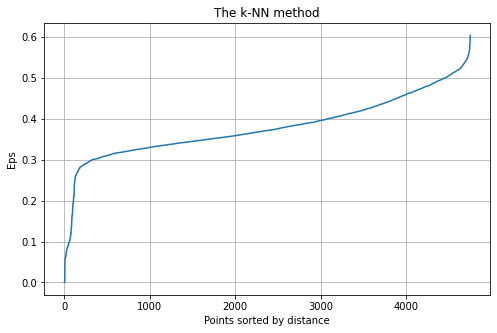

In [ ]:
# fit the function to plot the elbow method 
find_eps(normalized_images)

Based on the K-NN method and the result graph from above,  eps is chose to be in range of 0.3 to 0.5. 
Vairous values are tested out from below.

Visualizaitons below were made only with 2 columns(attributes) of the data, since there are 16000+ dimensions( attributes) of the data  and it is hard to visualize. 

Estimated number of clusters: 1
CPU times: user 19min 14s, sys: 548 ms, total: 19min 15s
Wall time: 19min 23s


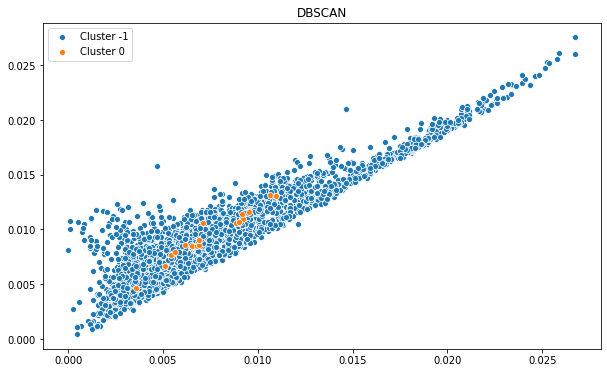

In [ ]:
%%time
# fit the DBSCAN model
DBSCAN_fit(data = normalized_images, eps = 0.3, min_samples = 10 )  # eps = 0.3 from K-NN method

Estimated number of clusters: 1


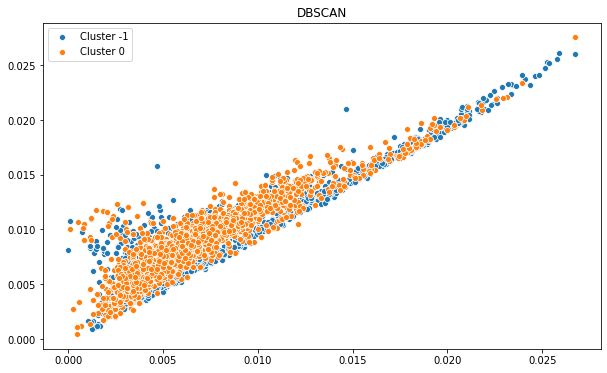

In [ ]:
# fit the DBSCAN model
# try eps = 0.4
DBSCAN_fit(data = normalized_images, eps = 0.4, min_samples = 10 )  

Estimated number of clusters: 1


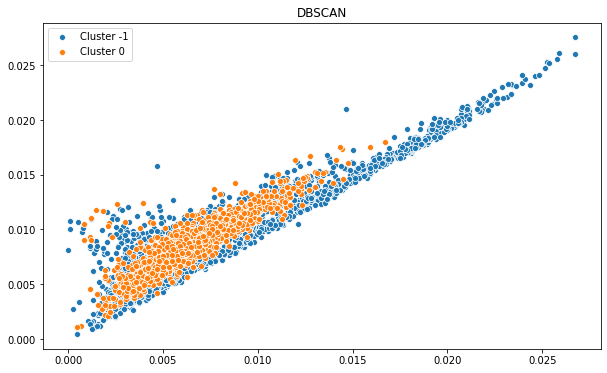

In [ ]:
# fit the DBSCAN model
# try eps = 0.35
DBSCAN_fit(data = normalized_images, eps = 0.35, min_samples = 10 )  

Estimated number of clusters: 0


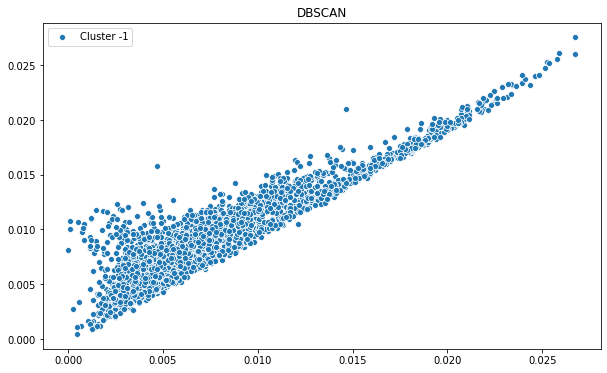

In [ ]:
# fit the DBSCAN model
# try eps = 0.3, min_sample = 100
DBSCAN_fit(data = normalized_images, eps = 0.3, min_samples = 100 )  

Estimated number of clusters: 1


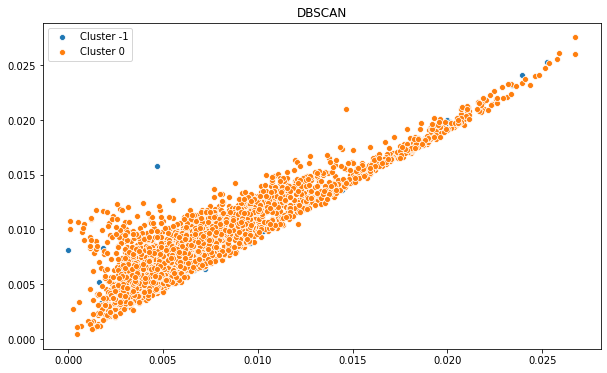

In [ ]:
# fit the DBSCAN model
# try eps = 0.53, min_sample = 100
DBSCAN_fit(data = normalized_images, eps = 0.53, min_samples = 100 )  

Estimated number of clusters: 0


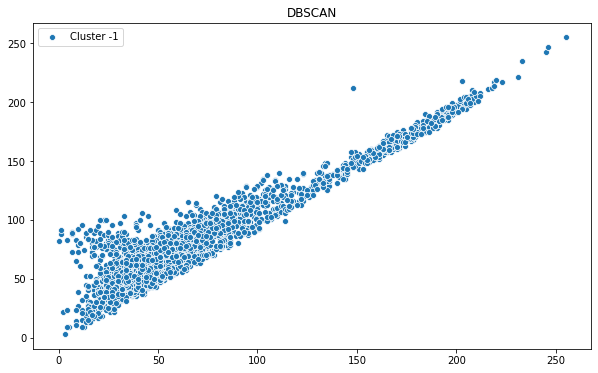

In [ ]:
# Try the non-normalized data array
DBSCAN_fit(data = x_train_2d, eps = 0.35, min_samples = 10 )  

### Try the test dataset 

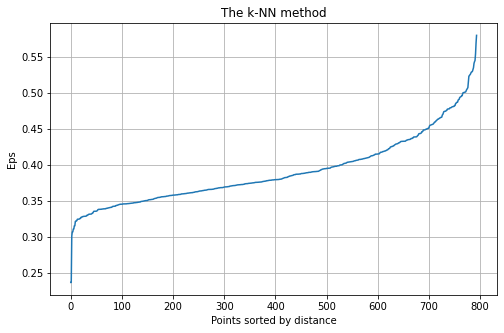

In [ ]:
find_eps(normalized_images_test)

Estimated number of clusters: 2


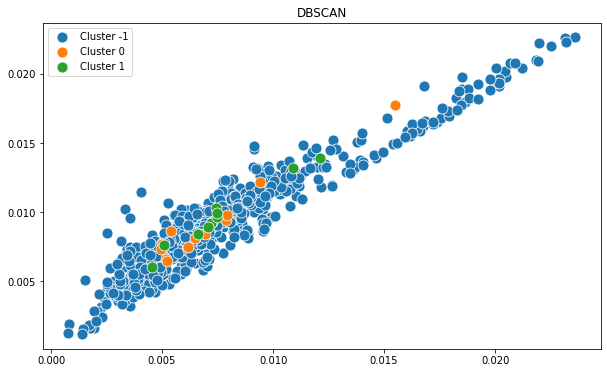

In [ ]:
# fit the DBSCAN model
# try eps = 0.35, min_sample = 10
DBSCAN_fit(data = normalized_images_test, eps = 0.35, min_samples = 10 )  

## K-Means 

Knowing clustering will not be a perfect fit to our image data the following K-means model is still tested. 
Inertia plot was used to determine the best number of K. However, the graph does not converge to a steady horizontal line. Thus we cannot expect too much out of K-Means model


In [ ]:
from sklearn.cluster import KMeans

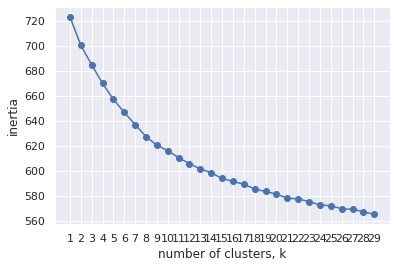

CPU times: user 1h 32min 7s, sys: 4min 15s, total: 1h 36min 22s
Wall time: 1h 21min 55s


In [ ]:
# Select the optimum number of clusters for k-means classification
%%time
ks = range(1, 30)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(normalized_images)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias onto a line graph to observe 'The elbow'
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 12, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
x_kmeans = kmeans.fit_predict(normalized_images)